In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, Trainer, TrainingArguments, logging
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
import torch.nn as nn
from tools import *
import torch
import os

In [21]:
device = "cuda"
checkpoint = "mistralai/Mistral-7B-v0.1"

config = AutoConfig.from_pretrained(checkpoint)
config.update({'sliding_window' : 8_192}) 
config.update({'rope_scaling' : {"type": "yarn",
                                 "factor": 2, 
                                 "original_max_position_embeddings": 8192,
                                 "finetuned": True,
                                }})  


tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast = False, revision = 'main')
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                            low_cpu_mem_usage = True,
                                            torch_dtype = torch.float16,
                                            revision = 'main',
                                            device_map = 'auto',
                                            use_flash_attention_2 = True,
                                            config = config,)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
lora_r_default = 8
lora_alpha_default = 32
lora_dropout_default = 0.05

lora_config = LoraConfig(
        r=lora_r_default, 
        lora_alpha=lora_alpha_default, 
        lora_dropout=lora_dropout_default,
        bias="none", 
        task_type="CAUSAL_LM",  
        target_modules = ["q_proj", "k_proj", "v_proj"],
        )

model.enable_input_require_grads()
model = get_peft_model(model, lora_config)

In [17]:
path = './model_weights/Mistral-7B-v0.1-context_extension-stage1/checkpoint_400.pt'

def load_weights(model, path):
    saved_weights = torch.load(path)
    param_count = 0
    for key, val in saved_weights['model_state_dict'].items():
        for name, param in model.named_parameters():
            if key == name:
                param.data = val.data
                param_count += val.numel()
                break
    
    print(f'{param_count:,} parameters were loaded successfully.')

load_weights(model, path)

In [33]:
for n,p in model.named_parameters():
    p.data = p.data.to(torch.float16)

In [ ]:
model.eval()
prompt = 'GPT-4 is '
inputs = tokenizer(prompt, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=200)
    print(tokenizer.decode(outputs[0, inputs['input_ids'].shape[1]:]))

# dataset

In [109]:
dataset = load_dataset('emozilla/yarn-train-tokenized-16k-mistral')['train']

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

In [51]:
def build_inputs(sample):
    prompt = '[INST] ' + sample['instruction'] + ' [\INST] ' + sample['output']
    inputs = tokenizer(prompt)
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': inputs['input_ids']}

In [52]:
dataset = dataset.map(build_inputs)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [76]:
dataset = dataset.filter(lambda x: len(x['input_ids']) <= 32768)

Filter:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [103]:
dataset = dataset.shuffle(seed=42)

In [104]:
train_dataset, val_dataset = split_dataset(dataset, 0.9)
datasets = DatasetDict({
    'train': train_dataset,
    'val': val_dataset
})

In [111]:
sizes = [len(x) for x in dataset['input_ids']]

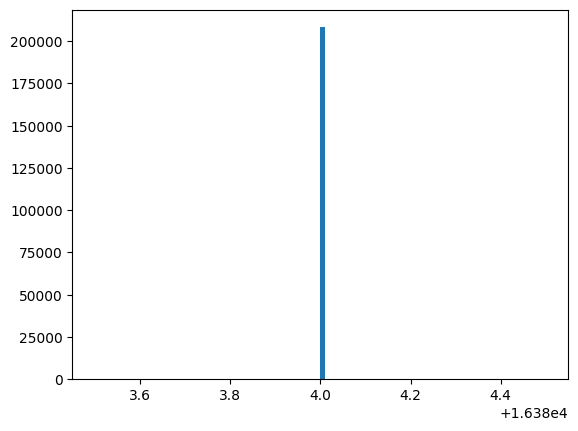

In [112]:
plt.hist(sizes, bins=100);

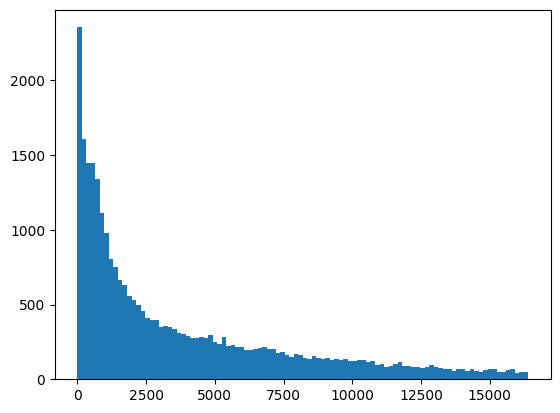

In [108]:
plt.hist(sizes, bins=100);

In [86]:
print(tokenizer.decode(dataset[1000]['input_ids']))

<s>[INST] Below is some paragraphs in the book, Wuthering Heights. Memorize the content and answer my question after the book.
 making her sad while I live, and leaving her solitary when I die.
Darling! I’d rather resign her to God, and lay her in the earth before
me.”

“Resign her to God as it is, sir,” I answered, “and if we should lose
you—which may He forbid—under His providence, I’ll stand her friend and
counsellor to the last. Miss Catherine is a good girl: I don’t fear
that she will go wilfully wrong; and people who do their duty are
always finally rewarded.”

Spring advanced; yet my master gathered no real strength, though he
resumed his walks in the grounds with his daughter. To her
inexperienced notions, this itself was a sign of convalescence; and
then his cheek was often flushed, and his eyes were bright; she felt
sure of his recovering. On her seventeenth birthday, he did not visit
the churchyard: it was raining, and I observed—

“You’ll surely not go out to-night, sir?”



In [46]:
dataset[6667]

{'output': "Based on the passages provided, the major relationships among the characters in the book are:\n\n1. Dorothea and Casaubon: Dorothea was married to Casaubon, but their relationship was fraught with difficulties. Dorothea chafed under Casaubon's control and demands, and felt restricted by him. After Casaubon's death, Dorothea realizes that their marriage did not meet her soul's needs. \n\n2. Dorothea and Celia (her sister): They have a close but somewhat unequal relationship. Celia seems to view Dorothea as selfless and uninterested in material things, whereas Dorothea values her independence. \n\n3. Dorothea and Will Ladislaw: Their relationship is only hinted at in the passages provided, but it seems they may develop a romantic connection in the future. Dorothea has feelings for Will that surprise her.\n\n4. Dorothea and Mr. Farebrother: They appear to have a respectful and thoughtful relationship. Mr. Farebrother acts as a mentor and friend to Dorothea.\n\n5. Fred Vincy an

In [44]:
l = []
for i,x in enumerate(dataset):
    if x['file'] is not None:
        l.append(i)
